In [2]:
# REMEMBER TO RUN THIS NOTEBOOK FROM THE "SSD" FOLDER, NOT "dataset_exploration"!
import torch
import os
import sys
import matplotlib.pyplot as plt
import numpy as np

# When not running from SSD-root folder
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from tops.config import instantiate, LazyConfig
from ssd import utils
from tqdm import tqdm

## Setup

In [3]:
def get_config(config_path):
    cfg = LazyConfig.load(config_path)
    cfg.train.batch_size = 1
    return cfg

In [4]:
def get_dataloader(cfg, dataset_to_visualize):
    if dataset_to_visualize == "train":
        # Remove GroundTruthBoxesToAnchors transform
        cfg.data_train.dataset.transform.transforms = cfg.data_train.dataset.transform.transforms[:-1]
        data_loader = instantiate(cfg.data_train.dataloader)
    else:
        cfg.data_val.dataloader.collate_fn = utils.batch_collate
        data_loader = instantiate(cfg.data_val.dataloader)

    return data_loader

In [5]:
config_path = "configs/tdt4265.py"
cfg = get_config(config_path)
n_bins = len(cfg.label_map.keys())
width, height = 1024, 128
print("Label map is:", cfg.label_map)


#Training Set
dataset_to_analyze = "train"
train_dataloader = get_dataloader(cfg, dataset_to_analyze)

#Validation Set
dataset_to_analyze = "val"
validate_dataloader = get_dataloader(cfg, dataset_to_analyze)

It looks like you are currently working on the server, with a 'working directory' in: /work/erikgal
Saving all SSD outputs to: /work/erikgal/ssd_outputs
Label map is: {0: 'background', 1: 'car', 2: 'truck', 3: 'bus', 4: 'motorcycle', 5: 'bicycle', 6: 'scooter', 7: 'person', 8: 'rider'}


## Analyzing Labels

In [6]:
def analyze_nbr_labels(dataloader, cfg):
    label_count = torch.zeros(len(cfg.label_map.keys()))
    for batch in tqdm(dataloader):
        label_count += torch.bincount(batch['labels'][0], minlength=n_bins)
    return label_count

In [7]:
train_labels = analyze_nbr_labels(train_dataloader, cfg)
vaildate_labels = analyze_nbr_labels(validate_dataloader, cfg)

100%|██████████| 301/301 [00:01<00:00, 224.25it/s]


[0.0, 6644.0, 79.0, 260.0, 0.0, 801.0, 474.0, 3865.0, 1163.0]


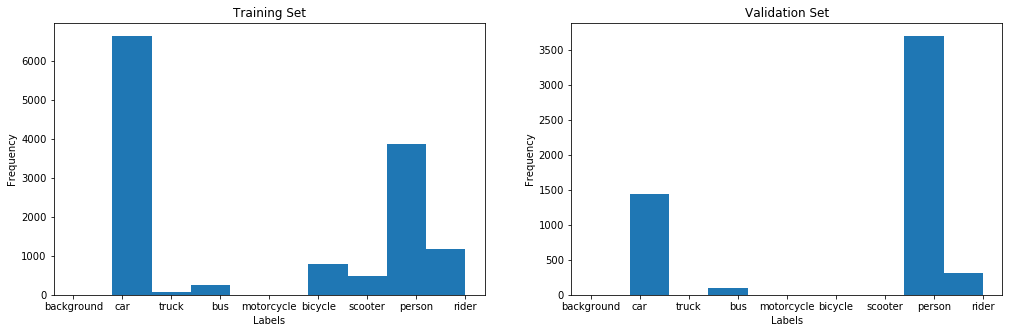

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(17, 5))
# We can set the number of bins with the *bins* keyword argument.
axs[0].hist(cfg.label_map.values(), weights=train_labels.tolist())
axs[0].set_title('Training Set')
axs[1].hist(cfg.label_map.values(), weights=vaildate_labels.tolist())
axs[1].set_title('Validation Set');

print(train_labels.tolist())

for ax in axs.flat:
    ax.set(xlabel='Labels', ylabel='Frequency')

## Analyzing Bounding Boxes

In [9]:
def analyze_bb_size(dataloader, cfg):
    bb_width = []
    bb_height= []
    sizes = []
    for i, batch in enumerate(tqdm(dataloader)):
        boxes = batch["boxes"][0]  # This is the only image in batch
        boxes[:, [0, 2]] *= width
        boxes[:, [1, 3]] *= height
        delta_w = boxes[:, [2]] - boxes[:, [0]]
        delta_h = boxes[:, [3]] - boxes[:, [1]]
        area = delta_w * delta_h
        
        bb_width += torch.flatten(delta_w).tolist()
        bb_height += torch.flatten(delta_h).tolist()
        sizes += torch.flatten(area).tolist()
    return bb_width, bb_height, sizes

In [10]:
train_width, train_height, train_sizes = analyze_bb_size(train_dataloader, cfg)
validate_width, validate_height, validate_sizes = analyze_bb_size(validate_dataloader, cfg)

100%|██████████| 301/301 [00:01<00:00, 233.87it/s]


### Width

TRAINING 
Max: 1012, Min: 2, Avg Width: 24

VALIDATION 
Max: 215, Min: 1, Avg Width: 14


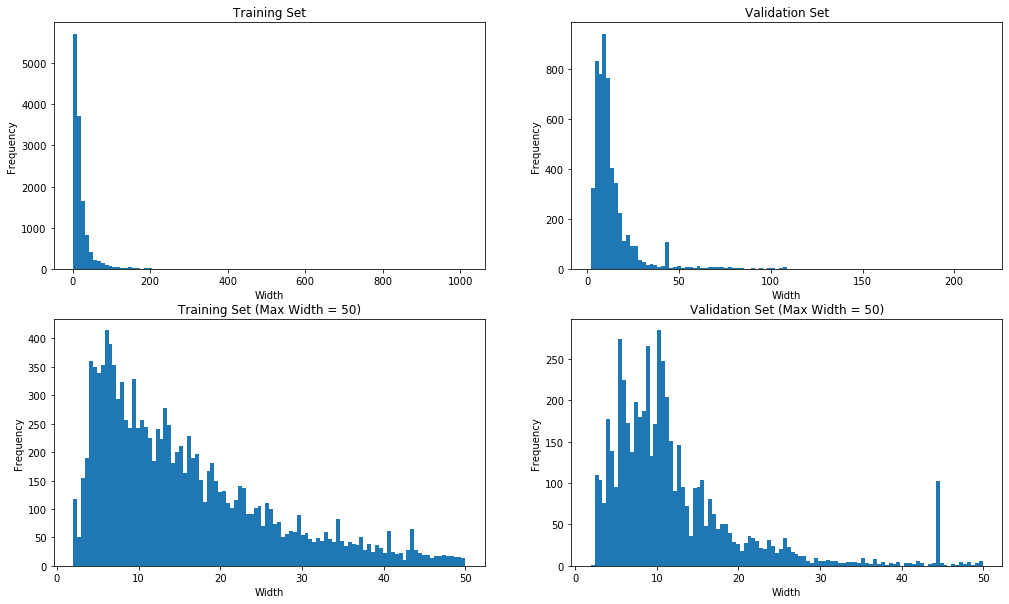

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(17, 10))
# We can set the number of bins with the *bins* keyword argument.
axs[0, 0].hist(train_width, bins=100)
axs[0, 0].set_title('Training Set')

axs[0, 1].hist(validate_width, bins=100)
axs[0, 1].set_title('Validation Set');

axs[1, 0].hist(list(filter(lambda score: score < 50, train_width)), bins=100)
axs[1, 0].set_title('Training Set (Max Width = 50)')

axs[1, 1].hist(list(filter(lambda score: score < 50, validate_width)), bins=100)
axs[1, 1].set_title('Validation Set (Max Width = 50)');

for ax in axs.flat:
    ax.set(xlabel='Width', ylabel='Frequency')

print(f'TRAINING \nMax: {int(max(train_width))}, Min: {int(min(train_width))}, \
Avg Width: {int(sum(train_width)/len(train_width))}')

print(f'\nVALIDATION \nMax: {int(max(validate_width))}, Min: {int(min(validate_width))}, \
Avg Width: {int(sum(validate_width)/len(validate_width))}')

### Height

TRAINING 
Max: 131, Min: 3, Avg Height: 30

VALIDATION 
Max: 90, Min: 5, Avg Height: 34


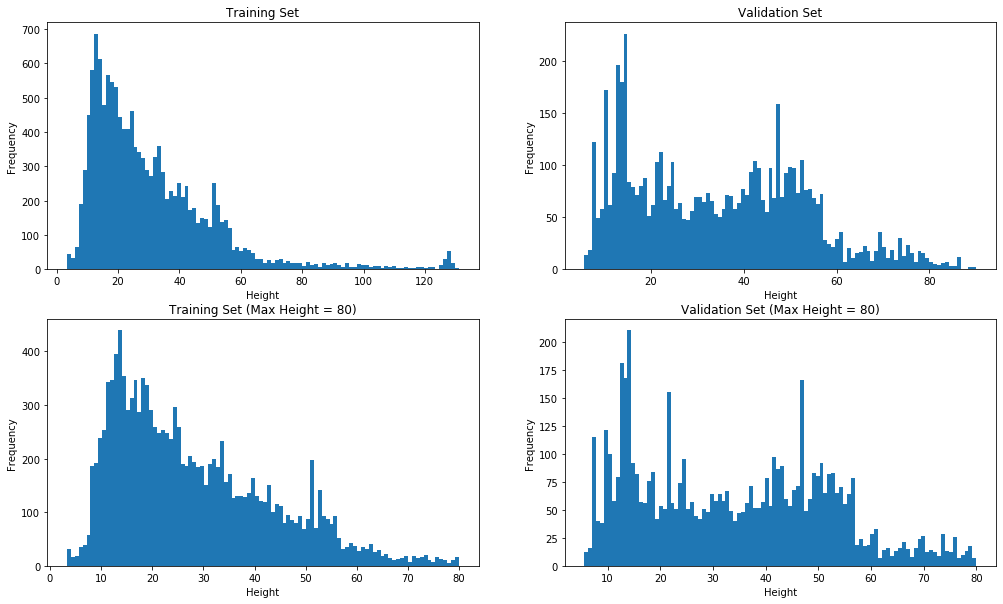

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(17, 10))
# We can set the number of bins with the *bins* keyword argument.
axs[0, 0].hist(train_height, bins=100)
axs[0, 0].set_title('Training Set')

axs[0, 1].hist(validate_height, bins=100)
axs[0, 1].set_title('Validation Set');

axs[1, 0].hist(list(filter(lambda score: score < 80, train_height)), bins=100)
axs[1, 0].set_title('Training Set (Max Height = 80)')

axs[1, 1].hist(list(filter(lambda score: score < 80, validate_height)), bins=100)
axs[1, 1].set_title('Validation Set (Max Height = 80)');

for ax in axs.flat:
    ax.set(xlabel='Height', ylabel='Frequency')

print(f'TRAINING \nMax: {int(max(train_height))}, Min: {int(min(train_height))}, \
Avg Height: {int(sum(train_height)/len(train_height))}')

print(f'\nVALIDATION \nMax: {int(max(validate_height))}, Min: {int(min(validate_height))}, \
Avg Height: {int(sum(validate_height)/len(validate_height))}')

### Width / Height

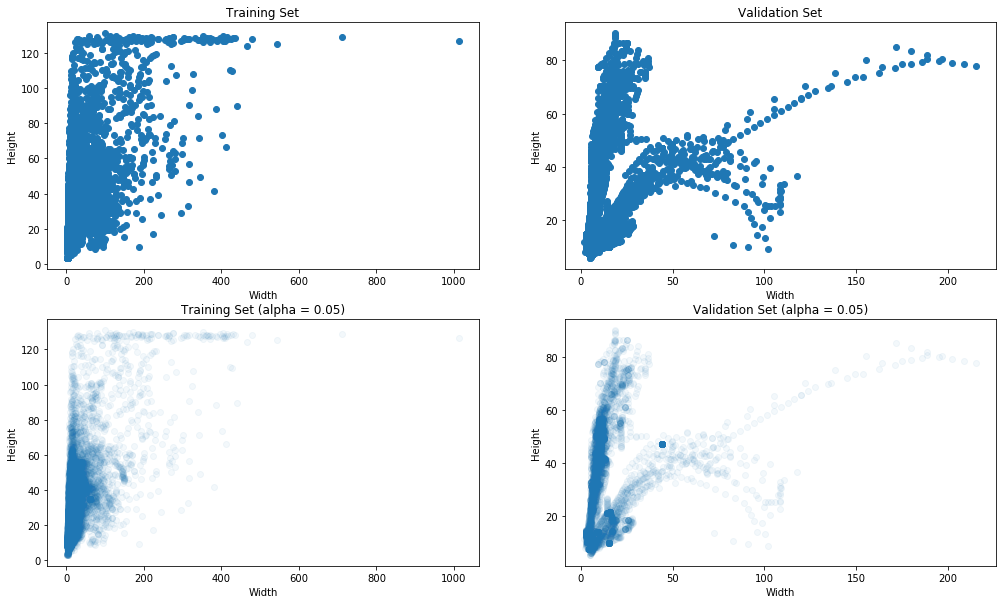

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(17, 10))
# We can set the number of bins with the *bins* keyword argument.
axs[0, 0].scatter(train_width, train_height)
axs[0, 0].set_title('Training Set')

axs[0, 1].scatter(validate_width, validate_height)
axs[0, 1].set_title('Validation Set');

axs[1, 0].scatter(train_width, train_height, alpha=0.05)
axs[1, 0].set_title('Training Set (alpha = 0.05)')

axs[1, 1].scatter(validate_width, validate_height, alpha=0.05)
axs[1, 1].set_title('Validation Set (alpha = 0.05)');

for ax in axs.flat:
    ax.set(xlabel='Width', ylabel='Height')
      

## Ratios

In [14]:
def analyze_bb_ratios(bb_width, bb_height):
    bb_width = np.array(bb_width)
    bb_height = np.array(bb_height)

    wh_ratio = bb_width/bb_height
    hw_ratio = bb_height/bb_width
    return wh_ratio, hw_ratio

In [15]:
train_wh_ratio, train_hw_ratio = analyze_bb_ratios(train_width, train_height)
validate_wh_ratio, validate_hw_ratio = analyze_bb_ratios(validate_width, validate_height)

### Width / Height

TRAINING 
Max: 19.829532650365227, Min: 0.0901669407512197, Avg Width/Height Ration: 0.8030731357447428

VALIDATION 
Max: 11.426965704591609, Min: 0.1111116169466126, Avg Width/Height Ration: 0.5074732135163127


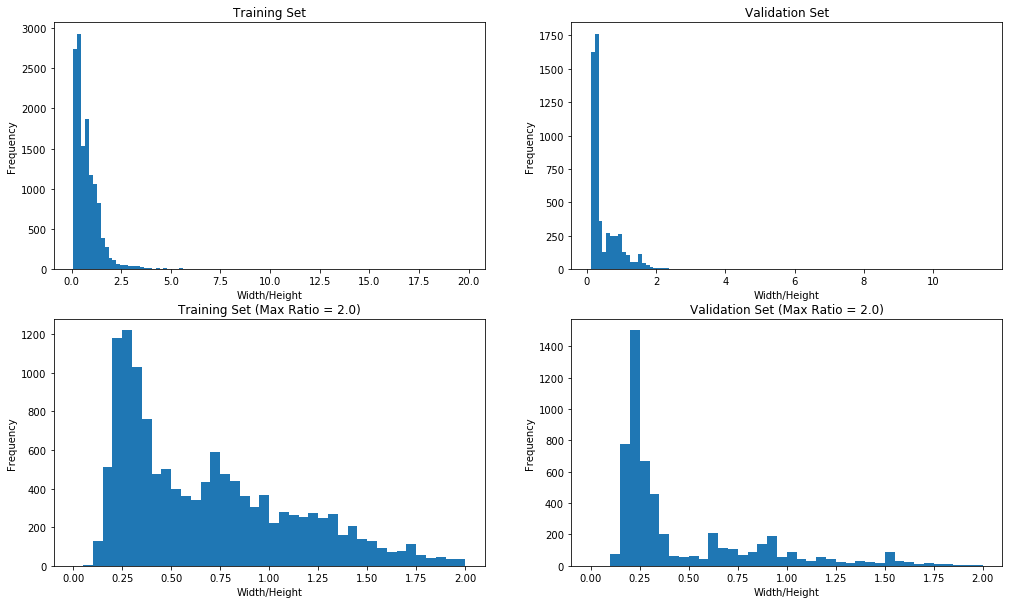

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(17, 10))
# We can set the number of bins with the *bins* keyword argument.
axs[0, 0].hist(train_wh_ratio, bins=100)
axs[0, 0].set_title('Training Set')

axs[0, 1].hist(validate_wh_ratio, bins=100)
axs[0, 1].set_title('Validation Set');

axs[1, 0].hist(train_wh_ratio, bins=[x/20 for x in range(41)])
axs[1, 0].set_title('Training Set (Max Ratio = 2.0)')

axs[1, 1].hist(validate_wh_ratio, bins=[x/20 for x in range(41)])
axs[1, 1].set_title('Validation Set (Max Ratio = 2.0)');

for ax in axs.flat:
    ax.set(xlabel='Width/Height', ylabel='Frequency')

print(f'TRAINING \nMax: {max(train_wh_ratio)}, Min: {min(train_wh_ratio)}, \
Avg Width/Height Ration: {sum(train_wh_ratio)/len(train_wh_ratio)}')

print(f'\nVALIDATION \nMax: {max(validate_wh_ratio)}, Min: {min(validate_wh_ratio)}, \
Avg Width/Height Ration: {sum(validate_wh_ratio)/len(validate_wh_ratio)}')

### Height / Width

TRAINING 
Max: 19.829532650365227, Min: 0.0901669407512197, Avg Height/Width Ration: 0.8030731357447428

VALIDATION 
Max: 11.426965704591609, Min: 0.1111116169466126, Avg Height/Width Ration: 0.5074732135163127


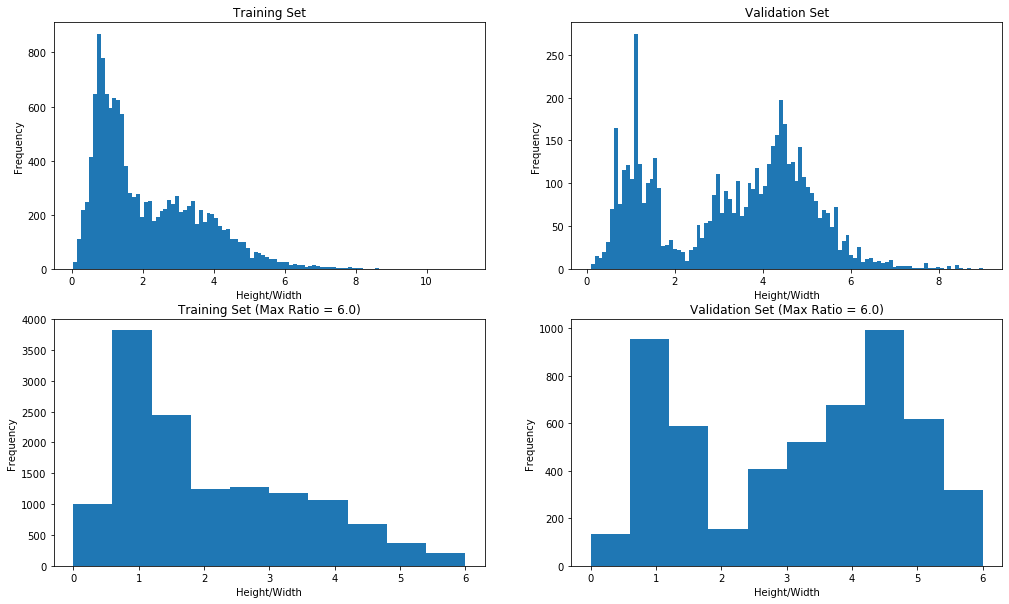

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(17, 10))
# We can set the number of bins with the *bins* keyword argument.
axs[0, 0].hist(train_hw_ratio, bins=100)
axs[0, 0].set_title('Training Set')

axs[0, 1].hist(validate_hw_ratio, bins=100)
axs[0, 1].set_title('Validation Set');

axs[1, 0].hist(train_hw_ratio, bins=[x*(6/10) for x in range(11)])
axs[1, 0].set_title('Training Set (Max Ratio = 6.0)')

axs[1, 1].hist(validate_hw_ratio, bins=[x*(6/10) for x in range(11)])
axs[1, 1].set_title('Validation Set (Max Ratio = 6.0)');

for ax in axs.flat:
    ax.set(xlabel='Height/Width', ylabel='Frequency')

print(f'TRAINING \nMax: {max(train_wh_ratio)}, Min: {min(train_wh_ratio)}, \
Avg Height/Width Ration: {sum(train_wh_ratio)/len(train_wh_ratio)}')

print(f'\nVALIDATION \nMax: {max(validate_wh_ratio)}, Min: {min(validate_wh_ratio)}, \
Avg Height/Width Ration: {sum(validate_wh_ratio)/len(validate_wh_ratio)}')

### Size and Aspect Ratio

In [18]:
def multi_filter_function(param1, param2, cap1, cap2):
    filtered_param1 = []
    filtered_param2 = []
    for p1, p2 in zip(param1, param2):
        if p1 <= cap1 and p2 <= cap2:
            filtered_param1.append(p1)
            filtered_param2.append(p2)
    return filtered_param1, filtered_param2

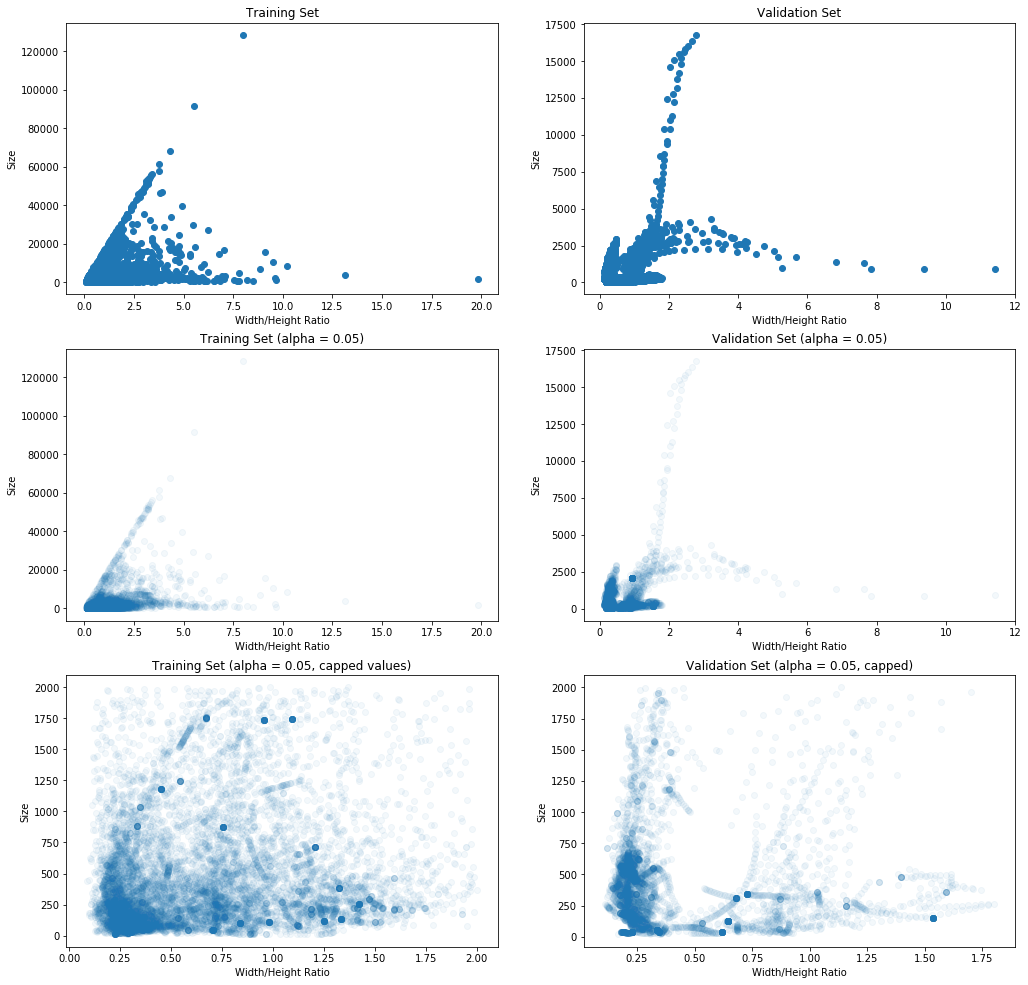

In [19]:
fig, axs = plt.subplots(3, 2, figsize=(17, 17))

# We can set the number of bins with the *bins* keyword argument.
axs[0, 0].scatter(train_wh_ratio, train_sizes)
axs[0, 0].set_title('Training Set')

axs[0, 1].scatter(validate_wh_ratio, validate_sizes)
axs[0, 1].set_title('Validation Set');

axs[1, 0].scatter(train_wh_ratio, train_sizes, alpha=0.05)
axs[1, 0].set_title('Training Set (alpha = 0.05)')

axs[1, 1].scatter(validate_wh_ratio, validate_sizes, alpha=0.05)
axs[1, 1].set_title('Validation Set (alpha = 0.05)');

filtered_x, filtered_y = multi_filter_function(train_wh_ratio, train_sizes, 2.0, 2000)
axs[2, 0].scatter(filtered_x, filtered_y , alpha=0.05)
axs[2, 0].set_title('Training Set (alpha = 0.05, capped values)')

filtered_x, filtered_y = multi_filter_function(validate_wh_ratio, validate_sizes, 2.0, 2000)
axs[2, 1].scatter(filtered_x, filtered_y , alpha=0.05)
axs[2, 1].set_title('Validation Set (alpha = 0.05, capped)');

for ax in axs.flat:
    ax.set(xlabel='Width/Height Ratio', ylabel='Size')

## Calculating Optimal min_sizes and aspect_ratios based on strides

In [20]:
 %%javascript
    IPython.OutputArea.auto_scroll_threshold = 9999

<IPython.core.display.Javascript object>

Calculated size range [0, 6.0, 12.0, 24.0, 48.0, 96.0, 1014] 

For interval of tile size 0 - 6.0 :
The average train bounding box are is 73, min: 10.62, max: 287.61
The average validate bounding box are is 81, min: 19.17, max: 262.44

For interval of tile size 6.0 - 12.0 :
The average train bounding box are is 201, min: 17.87, max: 1761.58
The average validate bounding box are is 317, min: 19.17, max: 905.13

For interval of tile size 12.0 - 24.0 :
The average train bounding box are is 375, min: 25.8, max: 3808.71
The average validate bounding box are is 425, min: 31.8, max: 2487.05

For interval of tile size 24.0 - 48.0 :
The average train bounding box are is 993, min: 98.65, max: 15860.94
The average validate bounding box are is 711, min: 123.1, max: 4324.25

For interval of tile size 48.0 - 96.0 :
The average train bounding box are is 2786, min: 252.18, max: 39502.09
The average validate bounding box are is 1285, min: 262.44, max: 16760.03

For interval of tile size 96.0 - 1014 :
Th

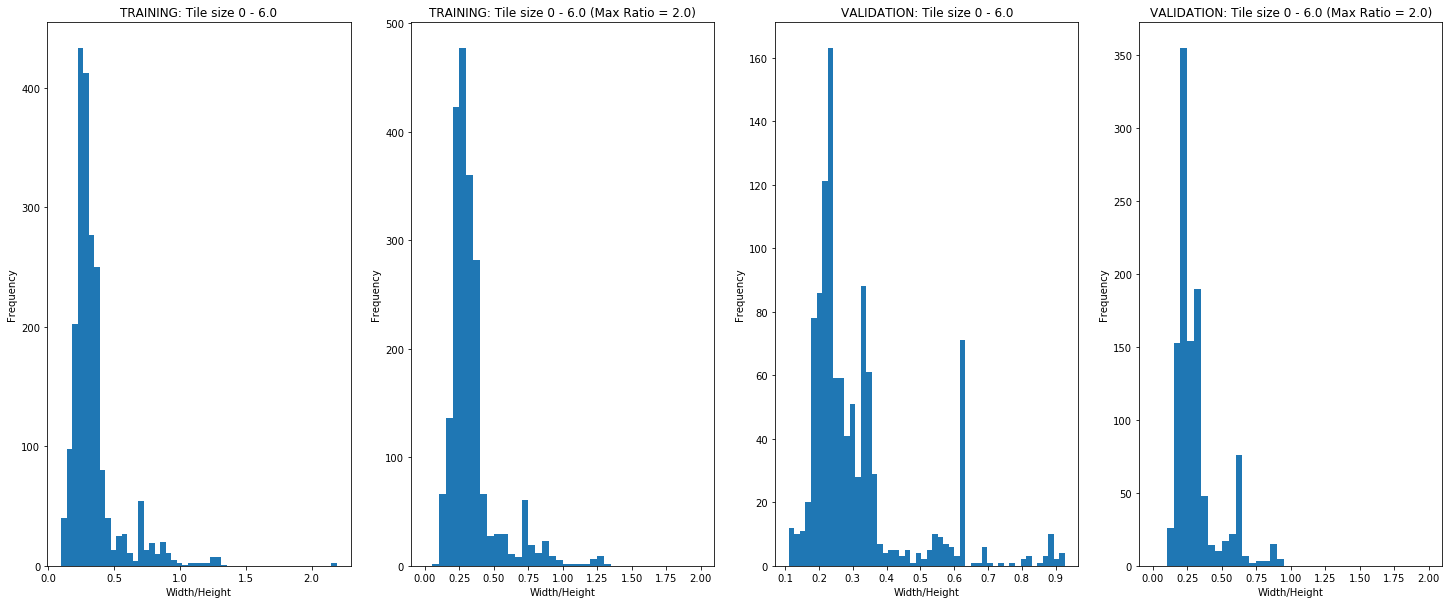

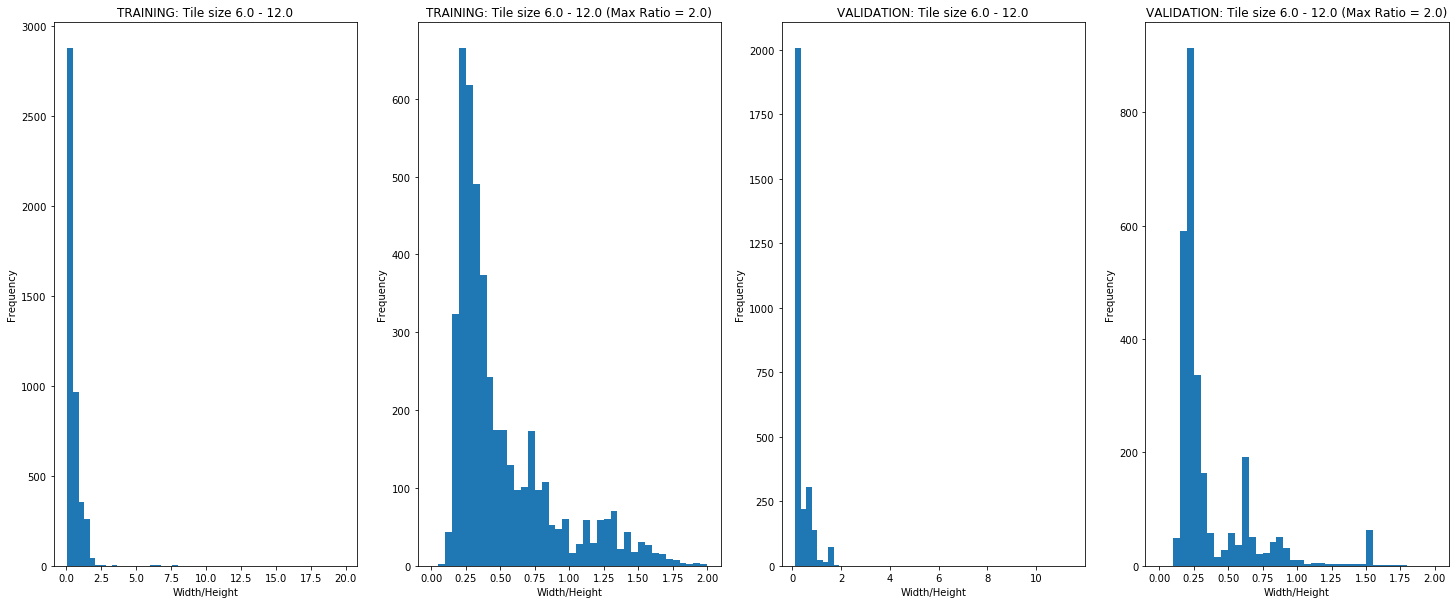

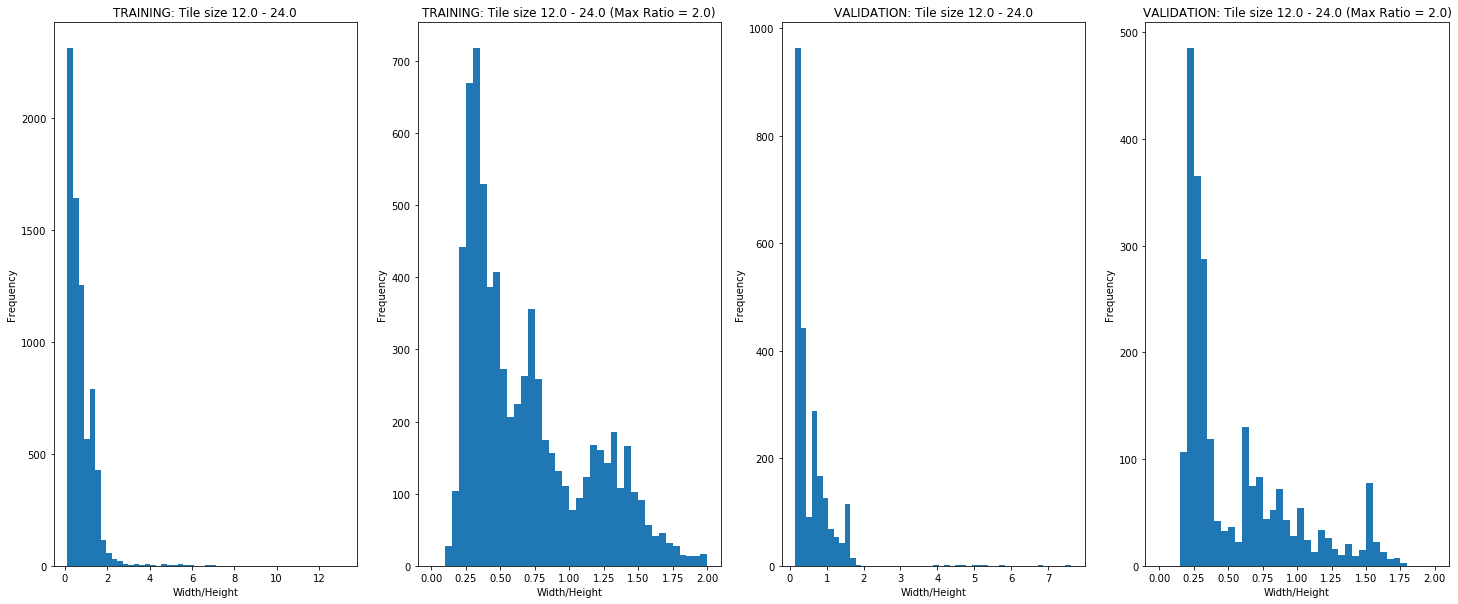

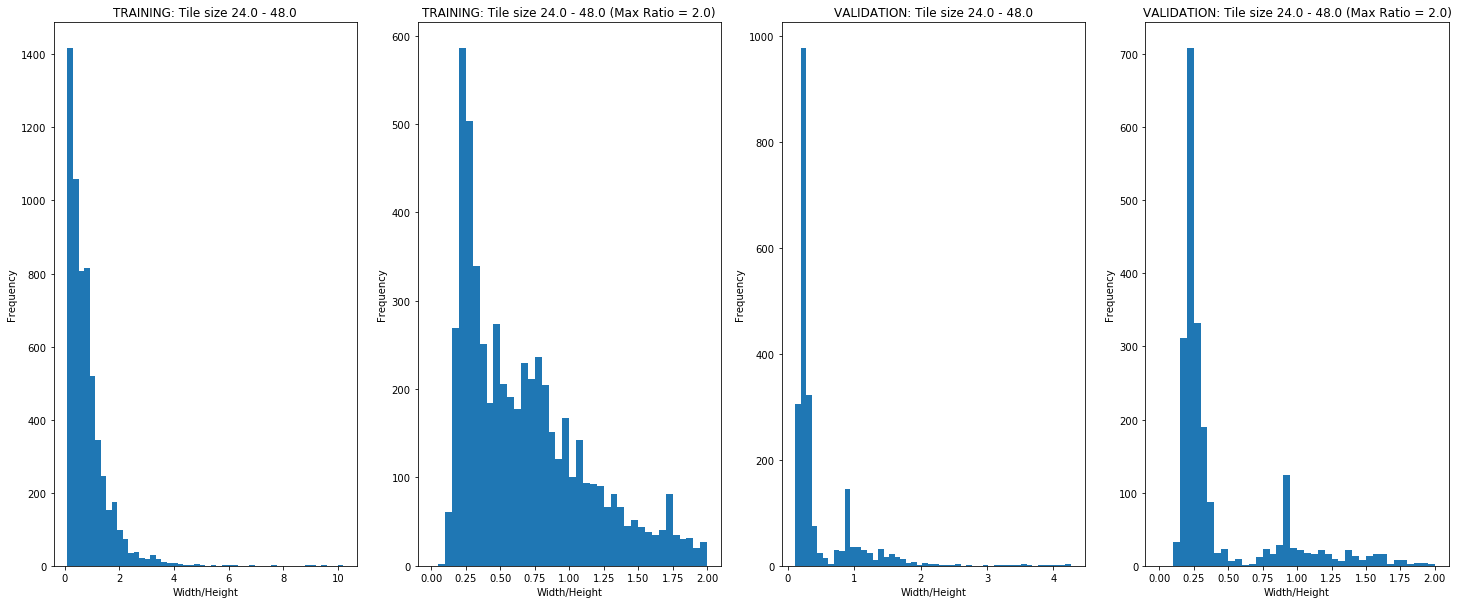

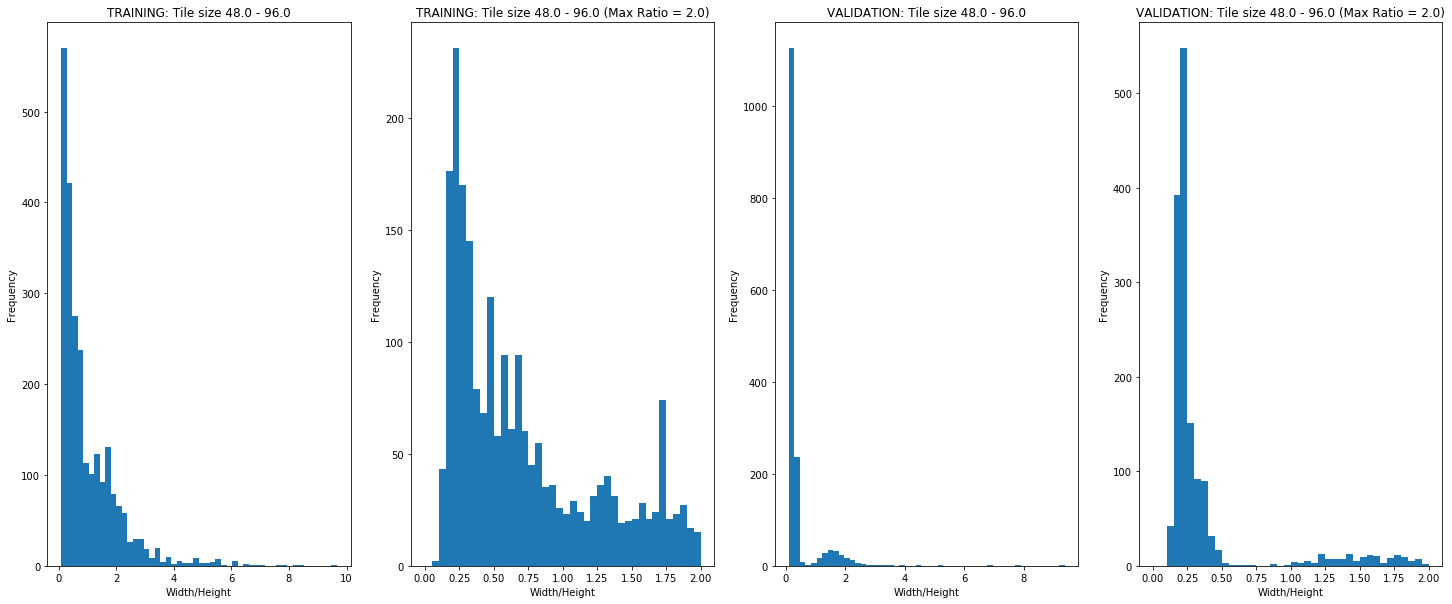

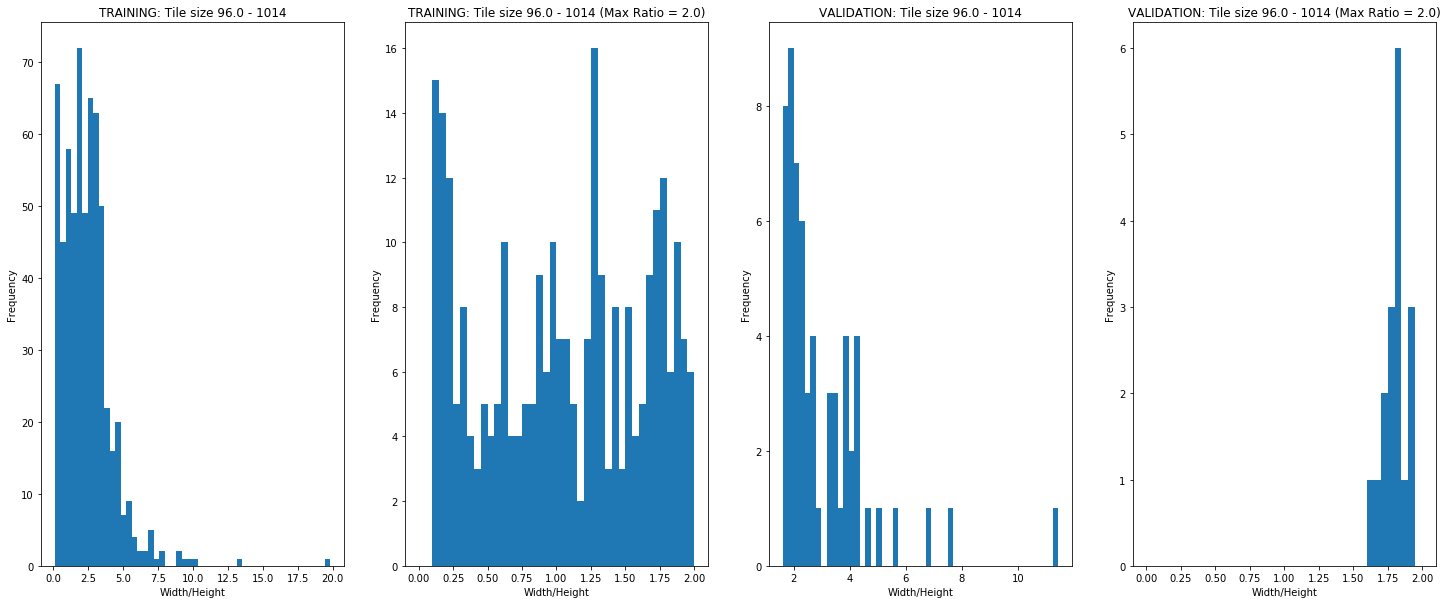

In [21]:
# Anchor box calculations:
# square of side min size
# square of side √(min size ∗ next min size)
# [min size ∗ √(aspect ratio), min size/√(aspect ratio)]
# [min size/√(aspect ratio), min size ∗ √(aspect ratio)]

# Default Anchor Box Recommendations:
feature_sizes = [[32, 256], [16, 128], [8, 64], [4, 32], [2, 16], [1, 8]]
strides= [[4, 4], [8, 8], [16, 16], [32, 32], [64, 64], [128, 128]]
min_sizes = [[16, 16], [32, 32], [48, 48], [64, 64], [86, 86], [128, 128], [128, 400]]
aspect_ratios = [[2, 3], [2, 3], [2, 3], [2, 3], [2], [2]]

# print([16 * np.sqrt(2), 16/ np.sqrt(2)]) => [22.627416997969522, 11.31370849898476]
# print([16 * np.sqrt(3), 16/ np.sqrt(3)]) => [27.712812921102035, 9.237604307034013]

# Describes the size intervals that should be tackled by the different anchors based on stride/tile_size
size_range = [0]
for i in range(len(feature_sizes)-1):
    size_range.append((strides[i][0] + strides[i+1][0])/2) 
# size_range.append(strides[-1][0]) 
size_range.append(int(max([max(train_width), max(validate_width)]) + 2))
print("Calculated size range", size_range, "\n")

# Gets all boxes within the correct interval with OR operator for size and width
def filter_size(width_lst, height_lst, interval):
    width_lst, height_lst = np.array(width_lst), np.array(height_lst)
    width_ind = np.where(np.logical_and(width_lst >= interval[0], width_lst <= interval[1]))[0].tolist()
    height_ind = np.where(np.logical_and(height_lst >= interval[0], height_lst <= interval[1]))[0].tolist()
        
    ind = list(set(width_ind + height_ind))
    ind.sort()
    
    return width_lst[np.array(ind)], height_lst[np.array(ind)]


def approximate_ratio_and_min_size(size_range):
    filtered_train_width, filtered_train_height = filter_size(train_width, train_height, size_range)
    filtered_train_size = filtered_train_width * filtered_train_height
    wh_train_ratio = filtered_train_width / filtered_train_height
    
    filtered_val_width, filtered_val_height = filter_size(validate_width, validate_height, size_range)
    filtered_val_size = filtered_val_width * filtered_val_height
    wh_val_ratio = filtered_val_width / filtered_val_height
    
    
    print(f"For interval of tile size {size_range[0]} - {size_range[1]} :") 
    print(f"The average train bounding box are is {int(np.average(filtered_train_size))}, min: {round(min(filtered_train_size), 2)}, max: {round(max(filtered_train_size), 2)}")
    print(f"The average validate bounding box are is {int(np.average(filtered_val_size))}, min: {round(min(filtered_val_size), 2)}, max: {round(max(filtered_val_size), 2)}\n")

    
    fig, axs = plt.subplots(1, 4, figsize=(25, 10))
    # We can set the number of bins with the *bins* keyword argument.
    axs[0].hist(wh_train_ratio, bins=50)
    axs[0].set_title(f'TRAINING: Tile size {size_range[0]} - {size_range[1]}')

    axs[1].hist(wh_train_ratio, bins=[x/20 for x in range(41)])
    axs[1].set_title(f'TRAINING: Tile size {size_range[0]} - {size_range[1]} (Max Ratio = 2.0)')
    
    axs[2].hist(wh_val_ratio, bins=50)
    axs[2].set_title(f'VALIDATION: Tile size {size_range[0]} - {size_range[1]}')

    axs[3].hist(wh_val_ratio, bins=[x/20 for x in range(41)])
    axs[3].set_title(f'VALIDATION: Tile size {size_range[0]} - {size_range[1]} (Max Ratio = 2.0)')
    
    for ax in axs.flat:
        ax.set(xlabel='Width/Height', ylabel='Frequency')
        
    plt.plot()


for i in range(len(size_range)-1):
    approximate_ratio_and_min_size([size_range[i], size_range[i+1]])
    
print("Ratios [0.25, 4] and [0.75, 1.25] look like good matches!")

In [22]:

def approximate_width_and_height(size_range):
    filtered_train_width, filtered_train_height = filter_size(train_width, train_height, size_range)
    
    filtered_val_width, filtered_val_height = filter_size(validate_width, validate_height, size_range)
    
    
    print(f"For interval of tile size {size_range[0]} - {size_range[1]} :") 
    print(f"The average train bounding boxes have width: {int(np.average(filtered_train_width))}, height: {int(np.average(filtered_train_height))}")
    print(f"The average validate bounding box are width: {int(np.average(filtered_val_width))}, height: {int(np.average(filtered_val_height))}")



for i in range(len(size_range)-1):
    approximate_width_and_height([size_range[i], size_range[i+1]])
    
print("Ratios [0.25, 4] and [0.75, 1.25] look like good matches!")

For interval of tile size 0 - 6.0 :
The average train bounding boxes have width: 4, height: 15
The average validate bounding box are width: 4, height: 17
For interval of tile size 6.0 - 12.0 :
The average train bounding boxes have width: 8, height: 22
The average validate bounding box are width: 8, height: 33
For interval of tile size 12.0 - 24.0 :
The average train bounding boxes have width: 14, height: 23
The average validate bounding box are width: 12, height: 29
For interval of tile size 24.0 - 48.0 :
The average train bounding boxes have width: 26, height: 35
The average validate bounding box are width: 17, height: 38
For interval of tile size 48.0 - 96.0 :
The average train bounding boxes have width: 49, height: 55
The average validate bounding box are width: 22, height: 57
For interval of tile size 96.0 - 1014 :
The average train bounding boxes have width: 156, height: 81
The average validate bounding box are width: 130, height: 52
Ratios [0.25, 4] and [0.75, 1.25] look like goo

##  Interesting samples

Even though the cyclist is not to small, easily visible and identifiable, there are no ground truth boxes in the video before the 2nd picture underneath. 

![Non-Visible Cyclist](dataset_exploration/annotation_images/image_491.png)
![Visible Cyclist](dataset_exploration/annotation_images/image_492.png)

Looks like groups og bicycles/scooters are either all labeled, or none.

![Non-identified scooters/bicycles](dataset_exploration/annotation_images/image_243.png)
![Identified scooters/bicycles](dataset_exploration/annotation_images/image_246.png)
![Identified scooters/bicycles](dataset_exploration/annotation_images/image_302.png)